In [1]:
import torch 
import torch.nn as nn
import lightning as L
from glob import glob

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from BalticRiverPrediction.convLSTM import ConvLSTM

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

from BalticRiverPrediction.BaltNet import BaltNet, LightningModel
from BalticRiverPrediction.BaltNet import AtmosphereDataModule, AtmosphericDataset
from BalticRiverPrediction.sharedUtilities import read_netcdfs, EnhancedMSELoss, EnhancedMSEMetric, PredictionPlottingCallback

from utility import loadData, PredictionData

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from scipy.stats import pearsonr

In [2]:
class PredictionData(Dataset):
    def __init__(self, input_size, atmosphericData, runoff, atmosStats, runoffStats, transform=None):

        self.input_size = input_size
        runoffData = runoff.transpose("time", "river")
        
        X = ((atmosphericData - atmosStats[0])/atmosStats[1]).compute()
        y = ((runoffData - runoffStats[0])/runoffStats[1]).compute()
        
        xStacked = X.to_array(dim='variable')
        xStacked = xStacked.transpose("time", "variable", "y", "x")

        assert xStacked.data.ndim == 4
        self.x = torch.tensor(xStacked.data, dtype=torch.float32)
        self.y = torch.tensor(y.data, dtype=torch.float32)

    def __getitem__(self, index):
        return self.x[index:index+(self.input_size)], self.y[index+int(self.input_size)]

    def __len__(self):
        return self.y.shape[0]-(self.input_size)

In [3]:
sns.set_theme(context='paper', style='whitegrid', palette='colorblind', font='DejaVu Serif', font_scale=1.2)

# Matplotlib default settings
plt.rcParams.update({
    'figure.figsize': (10, 15),
    'savefig.dpi': 300,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 12,
    'font.family': 'DejaVu Serif',
})


In [4]:
data, runoff = loadData()

The model will be loaded from a set of trained weights. Hence, the model paramters need to be set exactly like how they have been chosen during training.

In [5]:
modelParameters = {
"input_dim": 4,
"hidden_dim": 9,
"kernel_size": (7,7),
"num_layers": 1,
"batch_first": True,
"bias": True,
"return_all_layers": False,
"dimensions": (222,244),
"input_size": 30
}

pyTorchBaltNet = BaltNet(modelPar=modelParameters)

LightningBaltNet = LightningModel.load_from_checkpoint(
# checkpoint_path="/silor/boergel/paper/runoff_prediction/data/modelWeights/TrainCoupledModelMoreSensitive2TopOne-v2.ckpt",
#checkpoint_path="/silor/boergel/paper/runoff_prediction/data/modelWeights/TrainCoupledModelMoreSensitive3TopOne-v2.ckpt",
checkpoint_path="/silor/boergel/paper/runoff_prediction/data/modelWeights/TrainCoupledModelMoreSensitive5TopOne-v2.ckpt",
learning_rate=1e-3,
map_location="cpu",
model=pyTorchBaltNet,
cosine_t_max=100
)

In [6]:
# Used for the scaling of the NN prediction 
dataDataset = AtmosphericDataset(
    atmosphericData=data.sel(time=slice("1979", "2011")),
    runoff=runoff.sel(time=slice("1979", "2011")),
    input_size=modelParameters["input_size"],
)

dataLoader = AtmosphereDataModule(
    atmosphericData=data.sel(time=slice("1979", "2011")),
    runoff=runoff.sel(time=slice("1979", "2011")),
    batch_size=50,
    input_size=modelParameters["input_size"],
    num_workers=16
)

In [7]:
runoffPlaceHolder = xr.Dataset(dict(roflux=(["river", "time"], np.zeros((97, len(data.time))))),
                    coords={
                        "time":data.time,
                        "river":runoff.river
                    })

In [8]:
# Actual data for prediction
PredictionDataset = PredictionData(
    atmosphericData=data,
    runoff=runoffPlaceHolder.roflux,
    input_size=modelParameters["input_size"],
    atmosStats=dataDataset.atmosphericStats,
    runoffStats=dataDataset.runoffDataStats,
)

In [9]:
predict_dataloader = DataLoader(
    PredictionDataset,
    batch_size=50,
    shuffle=False,
    drop_last=True
    )

In [10]:
dataLoader.setup(stage="")

In [11]:
trainer = L.Trainer(
    inference_mode=True,
    accelerator="cuda",
    devices=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
predictions = trainer.predict(LightningBaltNet, dataloaders=predict_dataloader)

You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/silos/conda_packages/boergel/miniconda3_4.12.0/OS_15.4/conda_env/BaltNet/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [13]:
concatenated_predictions = torch.cat(predictions, dim=0) # concat in time
rescaledRunoffDataFull = concatenated_predictions*dataDataset.runoffDataStats[1].data+dataDataset.runoffDataStats[0].data

In [15]:
rescaledRunoffDataDataset = xr.DataArray(
    data = rescaledRunoffDataFull.data,
    coords={
        "time": runoffPlaceHolder.time[modelParameters["input_size"]:],
        "river": runoffPlaceHolder.river
    }
)

In [16]:
predictions = trainer.predict(LightningBaltNet, dataloaders=dataLoader.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [17]:
# Store actual river runoff of hydrological model in an array called `testData` 
testData = np.zeros((len(dataLoader.test), 97))
iterater = iter(dataLoader.test)
for i in range(len(dataLoader.test)):
    batch = next(iterater)[1]
    testData[i,:] = batch
    

In [18]:
concatenated_predictions = torch.cat(predictions, dim=0) # concat in time
rescaledRunoffData = concatenated_predictions*dataLoader.runoffDataStats[1].data+dataLoader.runoffDataStats[0].data
rescaledTestData = testData*dataLoader.runoffDataStats[1].data+dataLoader.runoffDataStats[0].data

In [19]:
runoffData = xr.Dataset(
    {
        "prediction":(("time", "river"), rescaledRunoffData),
        "original":(("time","river"), rescaledTestData)
    },
    coords={
        "time": np.arange(len(rescaledRunoffData)),
        "river":np.arange(97)
    }
)

In [20]:
Neva = pd.read_csv(
    "/silor/boergel/paper/runoff_prediction/data/runoffMeasurements/Neva.day", 
    sep=';', 
    skiprows=42,
    names=["Date", "time", "Original", "Calculated", "Flag"],
    encoding='ISO-8859-1',
    index_col=0)
Neva.index = pd.to_datetime(Neva.index)


In [21]:
Oder = pd.read_csv(
    "/silor/boergel/paper/runoff_prediction/data/runoffMeasurements/Odra.day", 
    sep=';', 
    skiprows=42,
    names=["Date", "time", "Original", "Calculated", "Flag"],
    encoding='ISO-8859-1',
    index_col=0)
Oder.index = pd.to_datetime(Oder.index)

In [22]:
Neman = pd.read_csv(
    "/silor/boergel/paper/runoff_prediction/data/runoffMeasurements/Neman.day", 
    sep=';', 
    skiprows=42,
    names=["Date", "time", "Original", "Calculated", "Flag"],
    encoding='ISO-8859-1',
    index_col=0)
Neman.index = pd.to_datetime(Neman.index)

In [23]:
UmeAlv = pd.read_csv(
    "/silor/boergel/paper/runoff_prediction/data/runoffMeasurements/UmeAlv.day", 
    sep=';', 
    skiprows=42,
    names=["Date", "time", "Original", "Calculated", "Flag"],
    encoding='ISO-8859-1',
    index_col=0)
UmeAlv.index = pd.to_datetime(UmeAlv.index)

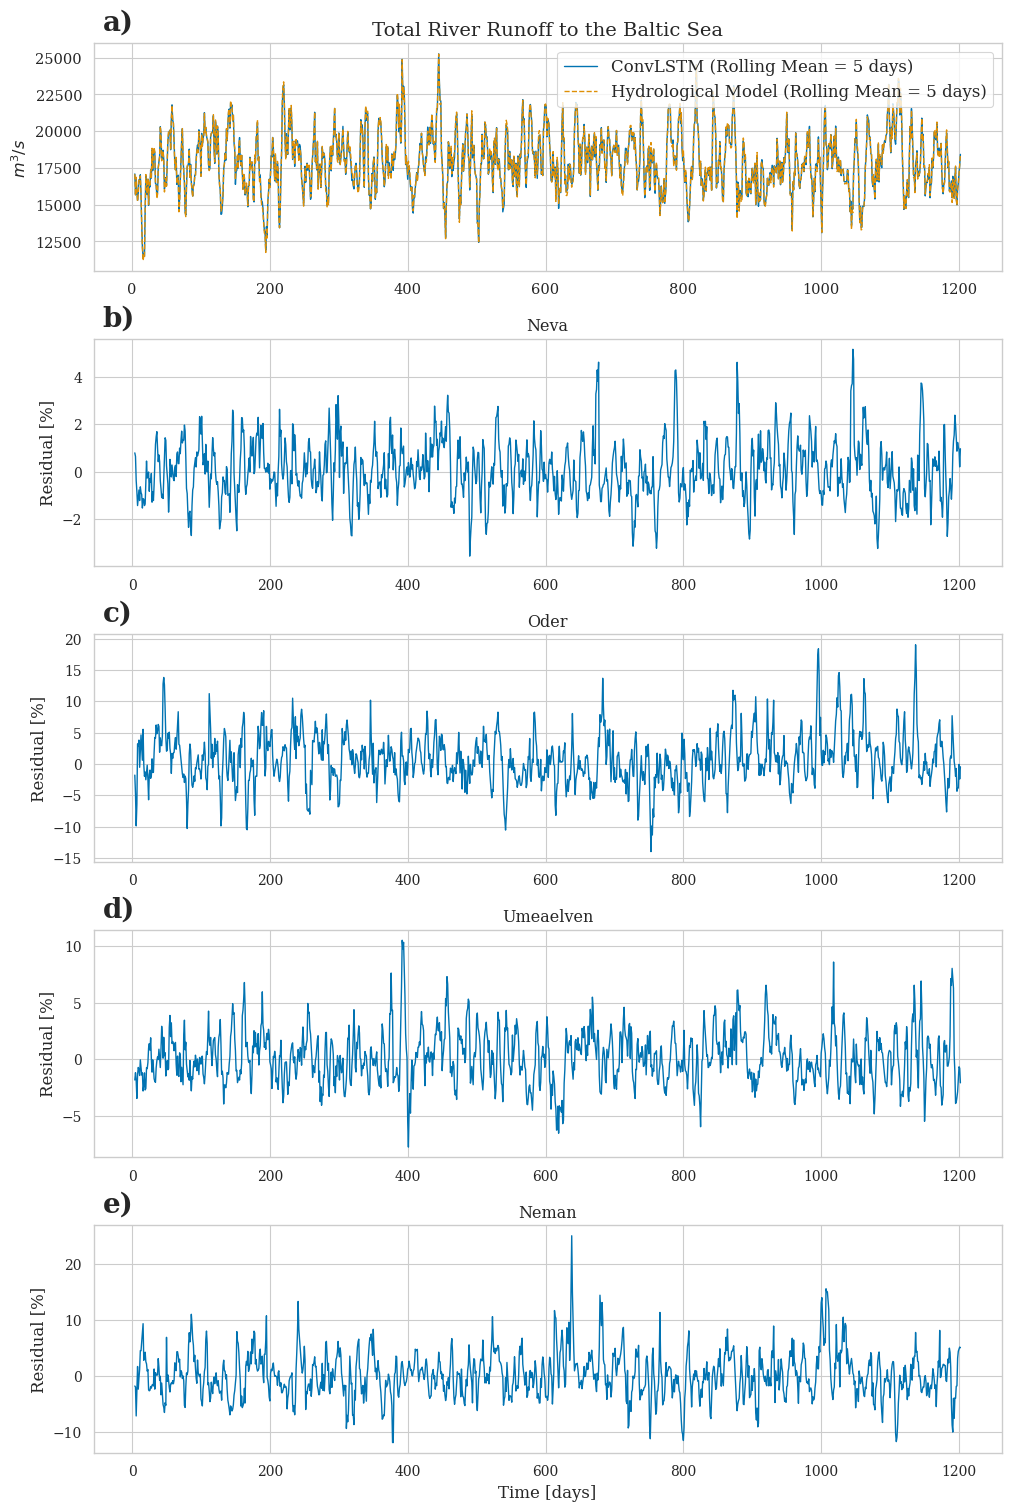

In [24]:
sns.set_theme(context='paper', style='whitegrid', palette='colorblind', font='DejaVu Serif', font_scale=1.2)

rolling_window_size = 5
fig = plt.figure(figsize=(10, 15),constrained_layout=True)
gs = fig.add_gridspec(nrows=5, ncols=1, left=0.05, right=0.95)

ax0 = fig.add_subplot(gs[0, :])
axes = [fig.add_subplot(gs[i+1, 0], sharex=ax0) for i in range(4)]

runoffData['prediction'].sum(dim='river').rolling(time=rolling_window_size).mean().plot(ax=ax0, label=f'ConvLSTM (Rolling Mean = {rolling_window_size} days)', linewidth=1)
runoffData['original'].sum(dim='river').rolling(time=rolling_window_size).mean().plot(ax=ax0, label=f'Hydrological Model (Rolling Mean = {rolling_window_size} days)', linewidth=1, linestyle='--')
ax0.set_title('Total River Runoff to the Baltic Sea', fontsize=14)
ax0.set_ylabel("$m^3/s$")
ax0.set_xlabel("")
# Adjust legend outside the plot area for ax0
ax0.legend(fontsize=12, loc='upper right')
ax0.text(0.01, 1.15, 'a)', transform=ax0.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')


annotations = ['b)', 'c)', 'd)', 'e)']  
largest_rivers = runoffData.sum(dim='time').to_array().sum(dim='variable').argsort()[::-1][0:4]

riversWithData = [56,2,78,15]

for i, river in enumerate(riversWithData):
    runoffData5d = runoffData.rolling(time=rolling_window_size).mean()
    residual = (runoffData5d.isel(river=river)['prediction'] - runoffData5d.sel(river=river)['original'])/runoffData5d.sel(river=river)['original']
    (residual*100).plot(ax=axes[i], label='Residual [%]', linewidth=1)
    # runoffData.sel(river=river)['prediction'].rolling(time=rolling_window_size).mean().plot(ax=axes[i], label='Prediction', linewidth=1)
    # runoffData.sel(river=river)['original'].rolling(time=rolling_window_size).mean().plot(ax=axes[i], label='Original', linewidth=1, linestyle='--')
    axes[i].text(0.01, 1.15, annotations[i], transform=axes[i].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')


axes[3].set_title("Neman")
axes[2].set_title("Umeaelven")
axes[1].set_title("Oder")
axes[0].set_title("Neva")

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_ylabel("Residual [%]", fontsize=12)
    ax.set_xlabel("", fontsize=12)

ax.set_xlabel("Time [days]", fontsize=12)

#fig.tight_layout()
fig.savefig("figures/paper_total_river_runoff.png", dpi=300)

In [25]:
listRiver = [Neva, Oder, UmeAlv, Neman]

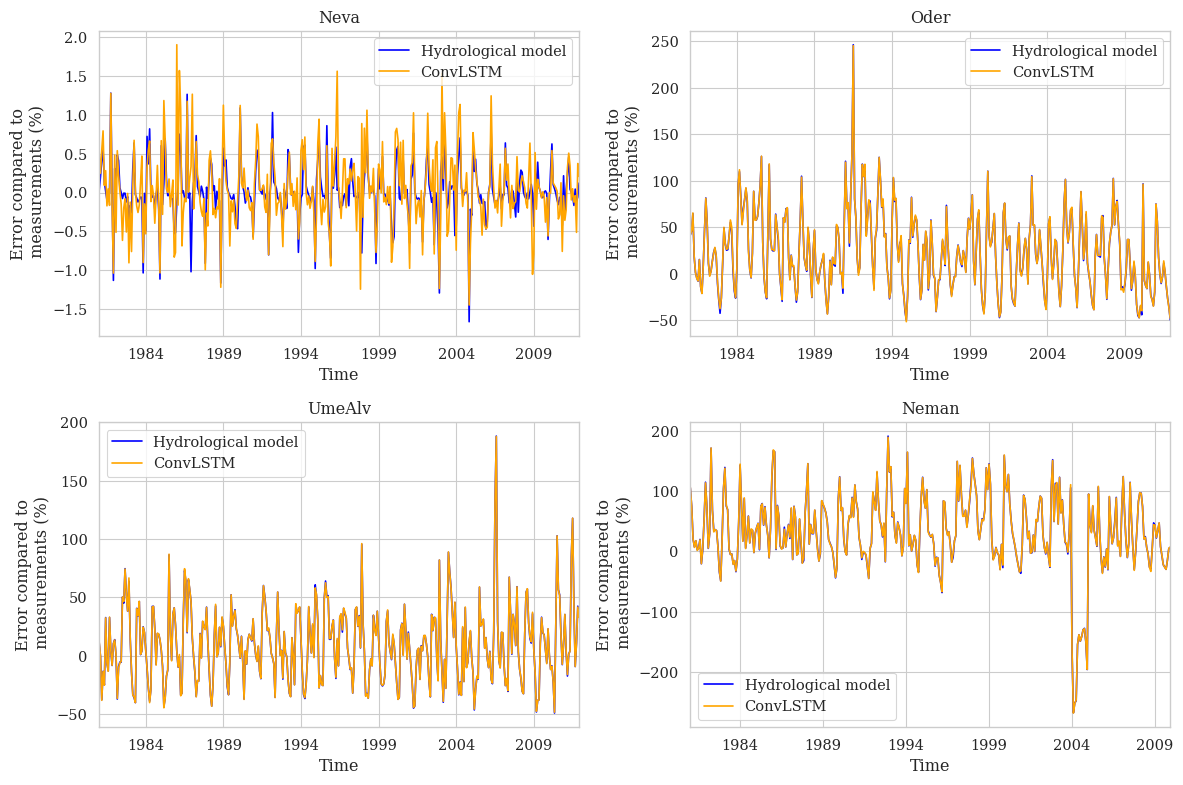

In [34]:
import matplotlib.pyplot as plt

# Create a 2x2 subplot structure
f, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()

listRiverNames = ["Neva", "Oder", "UmeAlv", "Neman"]

for i in range(4):
    # Resampling and calculations
    resampledRunoffSelect = runoff.sel(time=slice("1981","2011")).isel(river=riversWithData[i]).resample(time="M").sum().to_dataframe('Runoff')
    predictionNN = rescaledRunoffDataDataset.sel(time=slice("1981","2011")).isel(river=riversWithData[i]).resample(time="M").sum().to_dataframe('Runoff')
    resampledMeasurements = listRiver[i].loc["1981":"2011"].Calculated.resample("M").sum()
    
    aligned_df_NN = predictionNN.join(resampledMeasurements, how='inner')
    aligned_df = resampledRunoffSelect.join(resampledMeasurements, how='inner')

    aligned_df['Residuals'] = (aligned_df['Runoff'] - aligned_df['Calculated']) / resampledMeasurements
    aligned_df_NN["Residuals"] = (aligned_df_NN['Runoff'] - aligned_df_NN['Calculated']) / resampledMeasurements

    # Plotting residuals
    (aligned_df['Residuals'] * 100).plot(ax=ax[i], label="Hydrological model", color='blue')
    (aligned_df_NN['Residuals'] * 100).plot(ax=ax[i], label="ConvLSTM", color='orange')

    # Set titles and labels
    ax[i].set_title(f"{listRiverNames[i]}")
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Error compared to\n measurements (%)")

    # Add grid and legend
    ax[i].grid(True)
    ax[i].legend()

# Adjust layout
plt.tight_layout()

# Display the plot

plt.savefig("figures/supplementaryS2.png", dpi = 300)
plt.show()


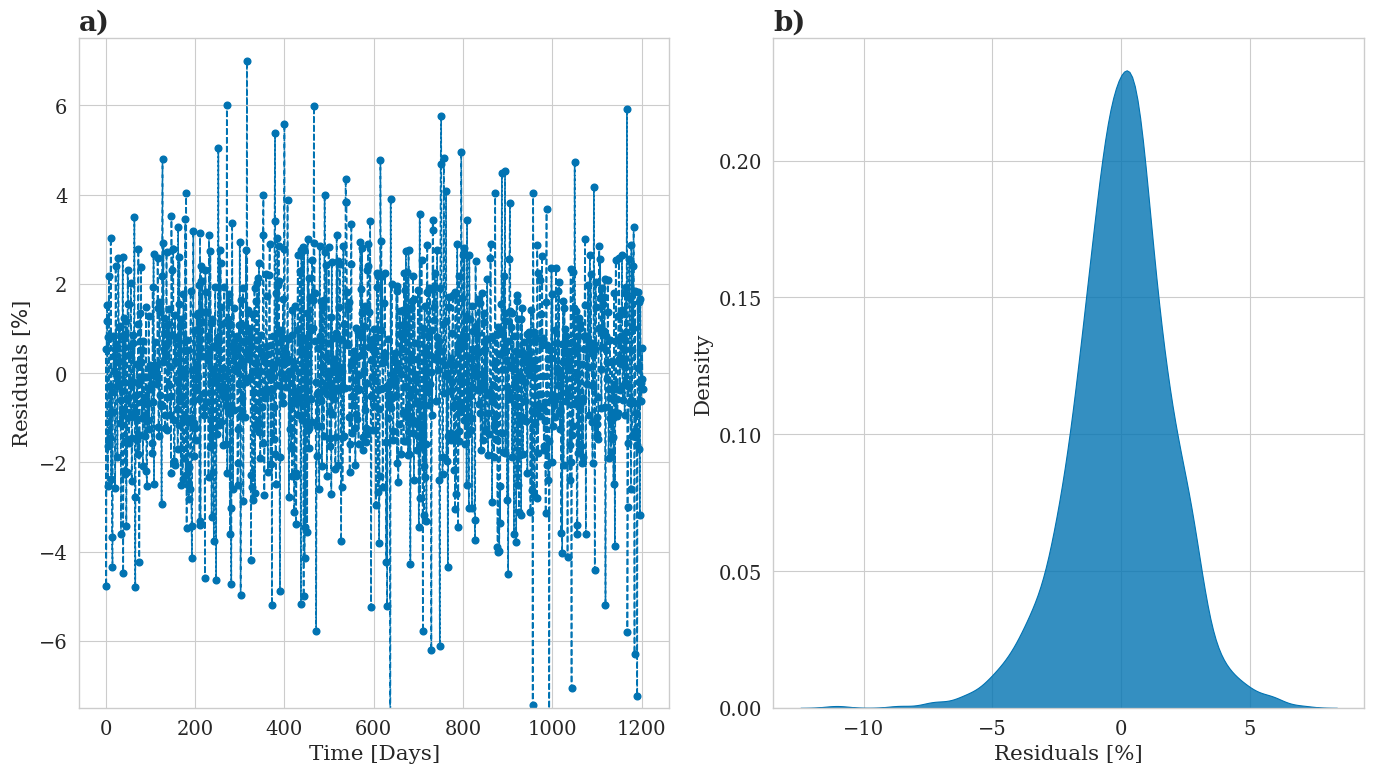

In [28]:


# Assuming 'runoffData' and 'rolling_window_size' are defined
# Placeholder for 'runoffData' structure, replace with your actual data loading logic

rolling_window_size = 1


def calculate_rmse(original, prediction):
    return np.sqrt(np.mean((original - prediction) ** 2))

def calculate_mae(original, prediction):
    return np.mean(np.abs(original - prediction))

def calculate_correlation(original, prediction):
    corr, _ = pearsonr(original, prediction)
    return corr

# Sum over all rivers and calculate rolling mean
summed_pred = runoffData['prediction'].sum(dim='river').rolling(time=rolling_window_size).mean().dropna('time')
summed_orig = runoffData['original'].sum(dim='river').rolling(time=rolling_window_size).mean().dropna('time')

# Calculate metrics
rmse_val = calculate_rmse(summed_orig, summed_pred)
mae_val = calculate_mae(summed_orig, summed_pred)
correlation_val = calculate_correlation(summed_orig, summed_pred)

# Plotting
sns.set_theme(context='paper', style='whitegrid', palette='colorblind', font='DejaVu Serif', font_scale=1.6)
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(14, 8))

metrics_text = f'RMSE: {rmse_val:.2f}\nMAE: {mae_val:.2f}\nCorrelation: {correlation_val:.3f}'

# Residual plot
residuals = summed_orig - summed_pred
residualsPct = residuals / summed_orig * 100
ax2.plot(summed_orig.time.values, residualsPct, marker='o', linestyle='--')
ax2.set_xlabel('Time [Days]')
ax2.set_ylabel('Residuals [$\%$]')
ax2.set_title('a)', loc="left", fontsize=20, fontweight="bold")
ax2.set_ylim([-7.5,7.5])
#ax2.annotate(metrics_text, xy=(0.05, -0.3), xycoords='axes fraction', fontsize=16, bbox=dict(boxstyle="round", fc="w"))

# Density plot for residuals
sns.kdeplot(residuals/summed_orig * 100, alpha=0.8, ax=ax3, fill=True)
ax3.set_xlabel('Residuals [%]')
ax3.set_title('b)', loc="left", fontsize=20, fontweight="bold")

fig.tight_layout()
fig.savefig("figures/paper_error_metrics.png", dpi=300)

In [29]:
WarnowriverRunoff = "/silod5/boergel/ocean_models_forcing/MOM_UERRA_FORCING/e-hype-runoff-raw/combined_fastriver_006.nc"

In [30]:
import skill_metrics as sm


In [31]:
listRiver = [Neva, Oder, UmeAlv, Neman]
riversWithData = [56,2,78,15]


In [32]:
runoff

<xarray.DataArray 'roflux' (time: 18993, river: 97)>
array([[ 25.89604128,  16.96186686, 340.37789917, ..., 161.78143311,
        203.82380676,   3.55322862],
       [ 26.15213587,  17.13992766, 343.9510882 , ..., 160.62340324,
        202.36483814,   3.52779465],
       [ 26.40823046,  17.31798847, 347.52427723, ..., 159.46537338,
        200.90586951,   3.50236067],
       ...,
       [ 26.67110062,  16.71035957, 187.04728699, ..., 428.19915771,
        519.69726562,  17.8742218 ],
       [ 28.06932068,  16.61111832, 187.64691162, ..., 418.31317139,
        508.81030273,  17.27508926],
       [ 36.25814438,  18.89372635, 188.54785156, ..., 409.12901306,
        498.52636719,  16.47635651]])
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-01-02 ... 2011-12-31
Dimensions without coordinates: river
Attributes:
    units:    m**3/s
    basin:    Kattegat
    lon:      11.097068
    lat:      53.974945

In [33]:
rescaledRunoffDataDataset

<xarray.DataArray (time: 18963, river: 97)>
array([[ 1.59078469e+02,  1.52498922e+02,  1.02737754e+03, ...,
         5.43823598e+01,  3.56105760e+02,  1.59709009e+00],
       [ 1.55596954e+02,  1.58218751e+02,  1.04333157e+03, ...,
         8.85279686e+01,  3.33898029e+02,  2.47981069e-01],
       [ 1.52793917e+02,  1.69777401e+02,  1.15110868e+03, ...,
         8.50509692e+01,  3.54381898e+02, -1.23625274e+00],
       ...,
       [ 2.72928733e+01,  1.71072885e+01,  1.74403599e+02, ...,
         4.11656145e+02,  5.37118981e+02,  1.79050352e+01],
       [ 2.72931697e+01,  1.50970490e+01,  2.01771837e+02, ...,
         4.28579366e+02,  5.12066196e+02,  1.71421600e+01],
       [ 3.66233802e+01,  1.94847466e+01,  1.85357582e+02, ...,
         4.15537011e+02,  4.87582579e+02,  1.68340942e+01]])
Coordinates:
  * time     (time) datetime64[ns] 1960-01-31 1960-02-01 ... 2011-12-31
  * river    (river) int64 0 1 2 3 4 5 6 7 8 9 ... 87 88 89 90 91 92 93 94 95 96

In [34]:
listRiver

[             time  Original  Calculated  Flag
 Date                                         
 1945-01-02  --:--    1610.0      1610.0  -999
 1945-01-03  --:--    1610.0      1610.0  -999
 1945-01-04  --:--    1610.0      1610.0  -999
 1945-01-05  --:--    1610.0      1610.0  -999
 1945-01-06  --:--    1610.0      1610.0  -999
 ...           ...       ...         ...   ...
 2011-12-27  --:--    2600.0      2600.0  -999
 2011-12-28  --:--    2690.0      2690.0  -999
 2011-12-29  --:--    2570.0      2570.0  -999
 2011-12-30  --:--    2530.0      2530.0  -999
 2011-12-31  --:--    2650.0      2650.0  -999
 
 [24470 rows x 4 columns],
              time  Original  Calculated  Flag
 Date                                         
 1920-11-02  --:--     311.0       311.0  -999
 1920-11-03  --:--     319.0       319.0  -999
 1920-11-04  --:--     317.0       317.0  -999
 1920-11-05  --:--     301.0       301.0  -999
 1920-11-06  --:--     303.0       303.0  -999
 ...           ...       ...   

In [35]:
runoffData

<xarray.Dataset>
Dimensions:     (time: 1203, river: 97)
Coordinates:
  * time        (time) int64 0 1 2 3 4 5 6 ... 1197 1198 1199 1200 1201 1202
  * river       (river) int64 0 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
Data variables:
    prediction  (time, river) float64 16.43 18.94 1.02e+03 ... 96.23 74.38 1.829
    original    (time, river) float64 14.68 19.7 950.5 ... 100.9 124.3 1.721

In [36]:
i = 0
resampledRunoffehype = runoff.sel(time=slice("1981","2011")).isel(river=riversWithData[i]).resample(time="M").sum().to_dataframe('Runoff')
resampledRunoffPredict = rescaledRunoffDataDataset.sel(time=slice("1981","2011")).isel(river=riversWithData[i]).resample(time="M").sum().drop("river").to_dataframe('Runoff')
resampledMeasurements = listRiver[i].loc["1981":"2011"].Calculated.resample("M").sum()

In [37]:
rescaledRunoffDataDataset.sel(time=slice("1981","2011")).isel(river=riversWithData[i]).resample(time="M").sum()

<xarray.DataArray (time: 372)>
array([ 38267.83409784,  41833.77001206,  49920.77800955,  75817.10950331,
        89732.45333478,  90643.02763052,  92370.86587129,  90882.11515886,
        86196.79070119,  87422.01431118,  88386.11131413,  60762.92457845,
        55426.02691142,  55762.71418985,  70507.81877736, 101523.86966187,
       114054.73414671, 112980.77851895, 115304.56308591, 110889.590617  ,
       103395.78512072, 102177.62866091,  93148.35496204,  94258.79742227,
        63121.61885717,  49738.83651238,  55216.66420988,  97783.20513523,
       103503.41180557,  98747.59191695,  98026.97339354,  93547.99100268,
        85871.40900838,  85619.86455131,  77048.96461077,  44913.84923638,
        42044.93171142,  38175.27072841,  58592.0069242 ,  90244.01114426,
       108512.50317452, 103802.1096369 , 103331.32085501,  97810.88447699,
        89880.29231204,  92301.00987591,  89076.88996565,  72372.79023494,
        48380.64816055,  50956.21175432,  55155.57703254,  75784.20033209,
        90681.41935356,  88302.91217133,  89816.10417376,  86691.65567418,
        82103.3241319 ,  82532.54894059,  75783.71140349,  42101.33663989,
        44093.59232854,  37858.80415368,  55447.48968531,  83813.36060379,
        92816.84641509,  91084.32273187,  91301.83376388,  87405.18173477,
        83620.95458022,  84063.84296489,  80187.94286577,  54078.75380852,
        47139.22860637,  43826.70881428,  51982.5171747 ,  77566.51800829,
        90346.50898598,  91875.83839594,  95949.20984076,  97849.66986587,
...
       109830.1225279 , 109448.15650093, 109617.58455562, 105296.84709661,
        95740.94802621,  94008.78027239,  84116.31944436,  70747.09235018,
        55967.6366555 ,  40380.62201801,  52102.33942216,  63885.4356675 ,
        84019.07030372,  80562.05672745,  78542.54198475,  71555.80062734,
        64669.49195734,  63342.41358494,  62628.12877681,  66181.10411361,
        56388.73371671,  47111.05495993,  67713.40518517,  81880.15299458,
        87269.01015338,  83170.81471605,  81004.16188776,  78481.6221975 ,
        75981.86555118,  77474.23080752,  64903.6257432 ,  67771.53779898,
        59056.83306792,  58053.60539769,  69400.0787058 ,  82726.77481454,
        91459.67116435,  86380.70985659,  86259.28782335,  83512.23037798,
        79874.23935765,  79382.22346437,  80536.84518288,  82926.41389765,
        72990.56106586,  62016.86173853,  75517.16461974,  80766.64848051,
       100318.31699783,  97795.16414034,  99980.08387085,  97698.71933282,
        91951.08456238,  94687.2663849 ,  91760.73594134,  78955.55649612,
        62569.06036828,  59906.18138111,  75515.84253795, 100761.8358395 ,
       109859.85923249, 106563.4524318 , 106937.83652135,  99061.16223037,
        89624.7301027 ,  86318.03042953,  78212.46228864,  67251.77288945,
        66311.95782726,  52681.52025421,  67211.91664023,  76958.32291843,
        94092.08737361,  92371.43514481,  93255.05940463,  87082.83162129,
        79846.85526658,  80434.69088571,  76524.70439338,  78572.25451358])
Coordinates:
    river    int64 56
  * time     (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2011-12-31

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

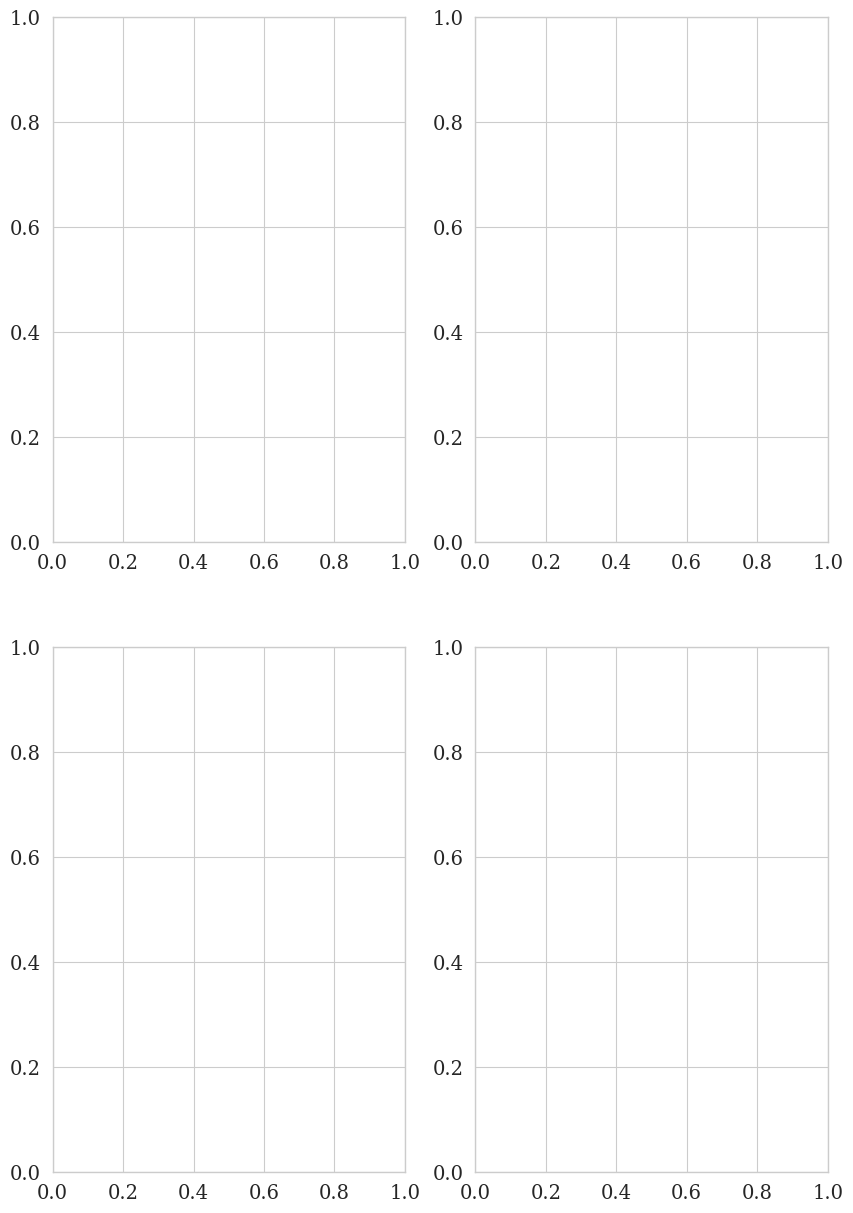

In [38]:
f, ax = plt.subplots(2, 2)
ax = ax.ravel()

listRiverNames = ["Neva", "Oder", "UmeAlv", "Neman"]


for i in range(4):
    resampledRunoffSelect = runoffData.sel(time=slice("1981","2011")).isel(river=riversWithData[i]).resample(time="M").sum().to_dataframe('Runoff')
    resampledMeasurements = listRiver[i].loc["1981":"2011"].Calculated.resample("M").sum()
    
    aligned_df = resampledRunoffSelect.join(resampledMeasurements, how='inner')
    aligned_df['Residuals'] = (aligned_df['Runoff'] - aligned_df['Calculated'])/resampledMeasurements

    (aligned_df['Residuals']*100).plot(ax=ax[i])
    ax[i].set_title(f"{listRiverNames[i]}")



In [ ]:
resampledRunoffPredict.values.shape

(372, 1)

In [ ]:
resampledRunoffPredict

,Runoff
time,
1981-01-31,32789.737694
1981-02-28,36517.634958
1981-03-31,55851.071833
1981-04-30,32286.277930
1981-05-31,19325.108842
...,...
2011-08-31,21190.007895
2011-09-30,10862.474225
2011-10-31,8318.353666


In [ ]:
resampledMeasurements

Date
1981-01-31    23083.0
1981-02-28    24951.0
1981-03-31    33734.0
1981-04-30    27219.0
1981-05-31    19006.0
               ...   
2011-08-31    20692.0
2011-09-30    12478.0
2011-10-31    11297.0
2011-11-30     9752.0
2011-12-31    11350.0
Freq: M, Name: Calculated, Length: 372, dtype: float64

In [ ]:
i = 0
resampledRunoffehype = runoff.sel(time=slice("1981","2011")).isel(river=riversWithData[i]).resample(time="M").sum().to_dataframe('Runoff')
resampledRunoffPredict = rescaledRunoffDataDataset.sel(time=slice("1981","2011")).isel(river=riversWithData[i]).resample(time="M").sum().drop("river").to_dataframe('Runoff')
resampledMeasurements = listRiver[i].loc["1981":"2011"].Calculated.resample("M").sum()
resampledMeasurement

In [ ]:
resampledMeasurements.index.name = "time"

In [ ]:
resampledMeasurements

time
1981-01-31    23083.0
1981-02-28    24951.0
1981-03-31    33734.0
1981-04-30    27219.0
1981-05-31    19006.0
               ...   
2011-08-31    20692.0
2011-09-30    12478.0
2011-10-31    11297.0
2011-11-30     9752.0
2011-12-31    11350.0
Freq: M, Name: Calculated, Length: 372, dtype: float64

<Axes: xlabel='time'>

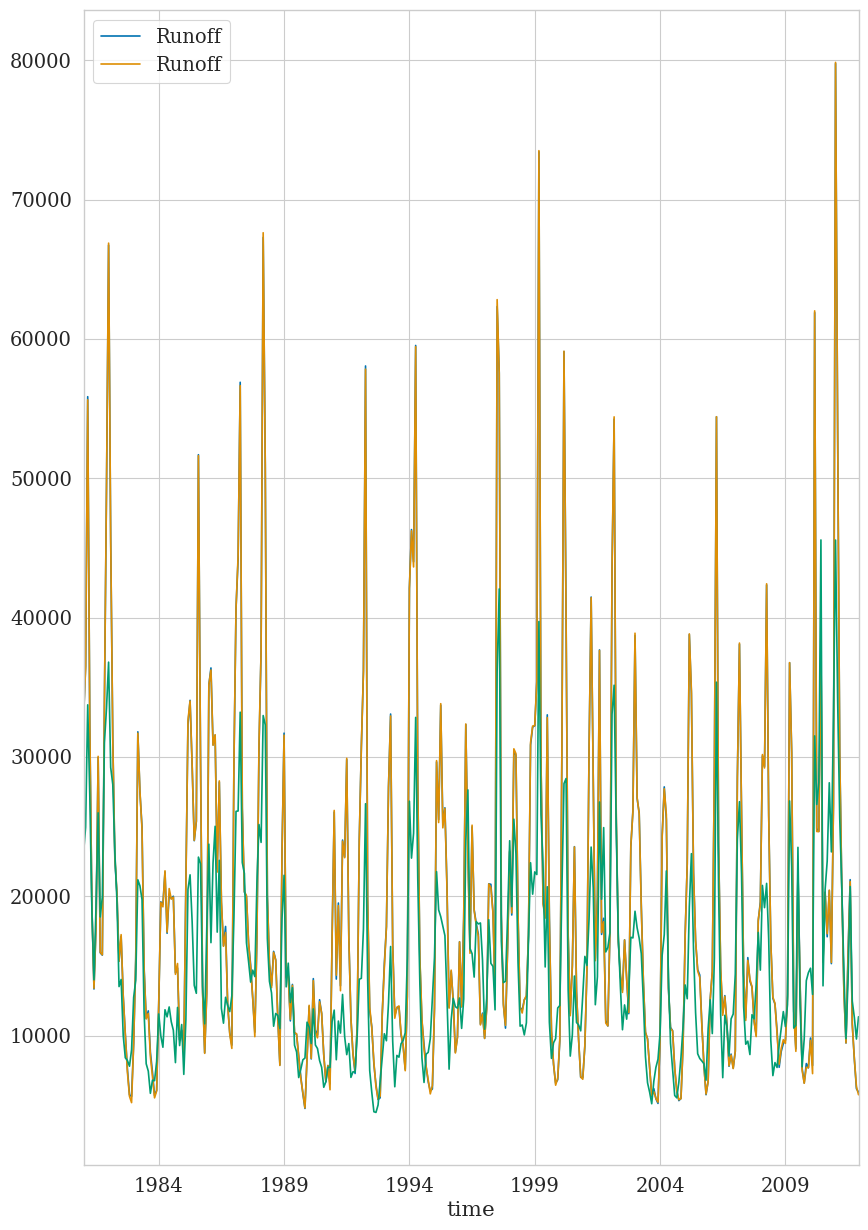

In [ ]:
f, ax = plt.subplots(1)

resampledRunoffPredict.plot(ax=ax)
resampledRunoffehype.plot(ax=ax)
resampledMeasurements.plot(ax=ax)

ValueError: 
*
*   The predicted and reference field dimensions do not match.
*       shape(predicted) = (372,)
*       shape(reference) = (348,)
*       predicted type: <class 'numpy.ndarray'>
*


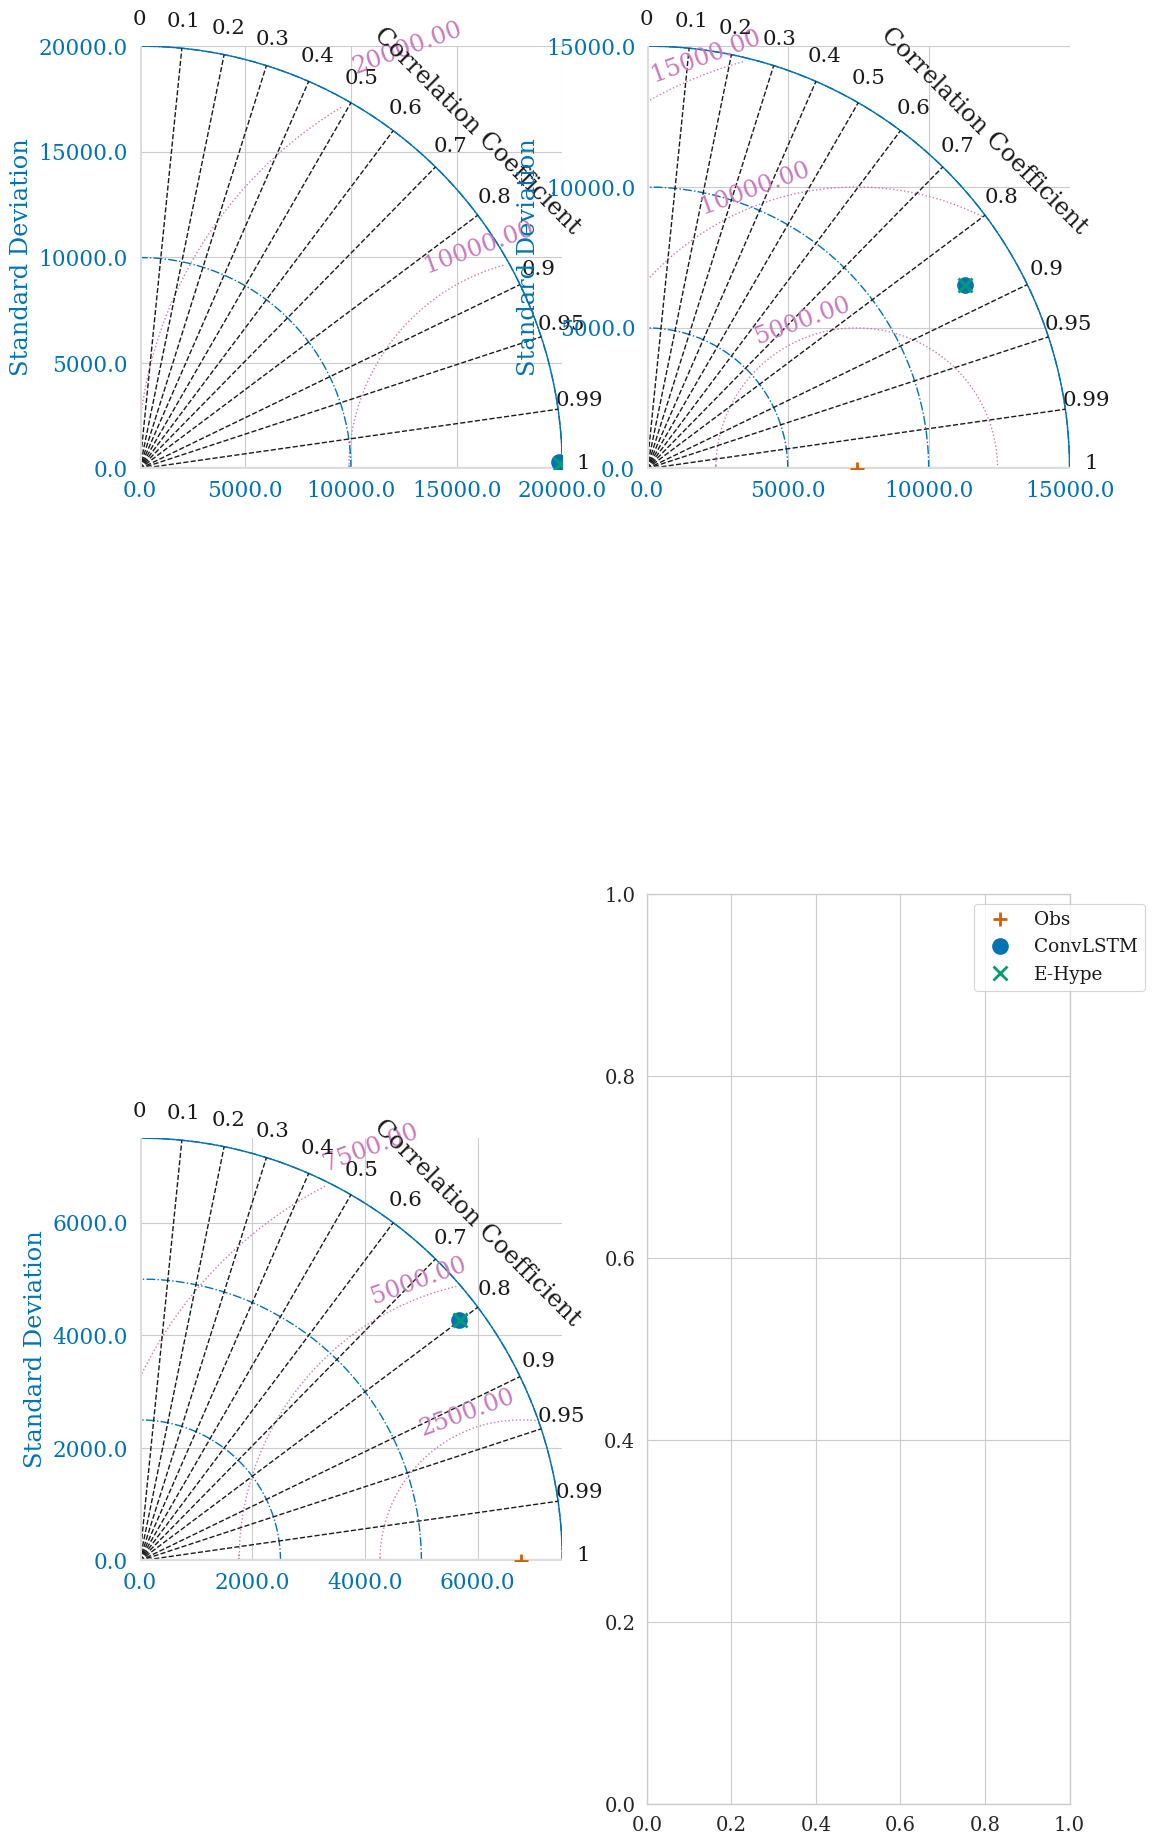

In [82]:
f, ax = plt.subplots(2, 2, sharex=False, figsize=(12, 26))
ax = ax.ravel()
for i in range(4):
    resampledRunoffehype = runoff.sel(time=slice("1981","2011")).isel(river=riversWithData[i]).resample(time="M").sum().to_dataframe('Runoff')
    resampledRunoffPredict = rescaledRunoffDataDataset.sel(time=slice("1981","2011")).isel(river=riversWithData[i]).resample(time="M").sum().drop("river").to_dataframe('Runoff')
    resampledMeasurements = listRiver[i].loc["1981":"2011"].Calculated.resample("M").sum()

    sdev = []
    crmsd = []
    ccoef = []
    label = []

    taylor_stats1 = sm.taylor_statistics(resampledRunoffPredict.values[:,0], resampledMeasurements.values, 'data')
    taylor_stats2 = sm.taylor_statistics(resampledRunoffehype.values[:,0], resampledMeasurements.values, 'data')

    sdev.extend([taylor_stats1['sdev'][0],taylor_stats1['sdev'][0], taylor_stats1['sdev'][1], taylor_stats2['sdev'][1]])
    crmsd.extend([taylor_stats1['crmsd'][0],taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1], taylor_stats2['crmsd'][1]])                    
    ccoef.extend([taylor_stats1['ccoef'][0],taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1], taylor_stats2['ccoef'][1]])
    # etc.). Note that a label needs to be specified for the reference even
    # though it is not used.
    label.extend(["Obs", "Obs", "ConvLSTM", "E-Hype"])

    sm.taylor_diagram(ax[i], np.asarray(sdev), np.asarray(crmsd), np.asarray(ccoef),
                        markerLabel = label,
                        markerLegend = 'on', 
                        tickRMSangle = 110.0,
                        rmsLabelFormat="0:.2f",
                        colRMS = 'm', styleRMS = ':', widthRMS = 1.0, 
                        titleRMS = 'off',  
                        colSTD = 'b', styleSTD = '-.', 
                        widthSTD = 1.0, titleSTD = 'on', 
                        colCOR = 'k', styleCOR = '--', widthCOR = 1.0, 
                        titleCOR = 'on',
                        colframe='#DDDDDD',
                        labelweight='normal',
                        titlecorshape='linear')